#### Customer segmentation is important to better understand customer groups, shopping desires and trends aiming to align relevant strategies and tactics to meet their distinctive needs and thus resulting in maximized customer loyalty and profits.

This notebook is to compare different clustering algorithms such as K-means and DBSCAN to find best clustering approach for the dataset. 

Data Source: https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset

### Part One: EDA


In [ ]:
%fs ls "FileStore/"

path,name,size,modificationTime
dbfs:/FileStore/Online_Retail_CSV.csv,Online_Retail_CSV.csv,46089548,1722021359000
dbfs:/FileStore/tables/,tables/,0,0


In [ ]:
%scala
import spark.implicits._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.expressions.Window
import org.apache.spark.sql.functions.col
import org.apache.spark.sql.types._
import org.apache.spark.sql.types.{
    StructType, StructField, StringType, IntegerType, DoubleType}
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.feature.StandardScaler
import org.apache.spark.ml.clustering.KMeans
import org.apache.spark.ml.evaluation.ClusteringEvaluator
import java.time.Period
import java.time._
import java.util.concurrent.TimeUnit
import java.sql.Timestamp
import java.util.Calendar;



import spark.implicits._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.expressions.Window
import org.apache.spark.sql.functions.col
import org.apache.spark.sql.types._
import org.apache.spark.sql.types.{StructType, StructField, StringType, IntegerType, DoubleType}
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.feature.StandardScaler
import org.apache.spark.ml.clustering.KMeans
import org.apache.spark.ml.evaluation.ClusteringEvaluator
import java.time.Period
import java.time._
import java.util.concurrent.TimeUnit
import java.sql.Timestamp
import java.util.Calendar

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score

In [ ]:
%scala
val df = spark.read.format("csv")
  .option("header", "true")
  .option("inferSchema", "true")
  .load("/FileStore/Online_Retail_CSV.csv")


df.printSchema()
df.show(5)

root
-- InvoiceNo: string (nullable = true)
-- StockCode: string (nullable = true)
-- Description: string (nullable = true)
-- Quantity: integer (nullable = true)
-- InvoiceDate: timestamp (nullable = true)
-- UnitPrice: double (nullable = true)
-- CustomerID: integer (nullable = true)
-- Country: string (nullable = true)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
InvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice|CustomerID| Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
 536365| 85123A|WHITE HANGING HEA...| 6|2010-12-01 08:26:00| 2.55| 17850|United Kingdom|
 536365| 71053| WHITE METAL LANTERN| 6|2010-12-01 08:26:00| 3.39| 17850|United Kingdom|
 536365| 84406B|CREAM CUPID HEART...| 8|2010-12-01 08:26:00| 2.75| 17850|United Kingdom|
 536365| 84029G|KNITTED UNION FLA...| 6|2010-12-01 08:26:00| 3.39| 17850|United Kingdom|
 536365| 84029E|RED WOOLLY HOTTIE...| 6|2010-12-01 08:26:00| 3.39| 17850|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows

df: org.apache.spark.sql.DataFrame = [InvoiceNo: string, StockCode: string ... 6 more fields]

In [ ]:
%scala
val missingValues = df.columns.map(col => (col, df.filter(df(col).isNull).count))
missingValues.foreach{case (col, count) => println(s"$col: $count missing values")}

InvoiceNo: 0 missing values
StockCode: 0 missing values
Description: 1454 missing values
Quantity: 0 missing values
InvoiceDate: 0 missing values
UnitPrice: 0 missing values
CustomerID: 135080 missing values
Country: 0 missing values
missingValues: Array[(String, Long)] = Array((InvoiceNo,0), (StockCode,0), (Description,1454), (Quantity,0), (InvoiceDate,0), (UnitPrice,0), (CustomerID,135080), (Country,0))

Clean the dataset as below:

In [ ]:
%scala

// Drop rows with missing values in critical columns (Description, CustomerID)
val dfCleaned = df.na.drop("any", Seq("Description", "CustomerID"))

// Remove duplicates
val dfCleanedNoDuplicates = dfCleaned.dropDuplicates()

// Filter out invalid data (Quantity and UnitPrice should be positive)
val df1 = dfCleanedNoDuplicates.filter(col("Quantity") > 0).filter(col("UnitPrice") > 0)

// Show the cleaned DataFrame
df1.show()

// Register the cleaned DataFrame as a SQL temporary view
df1.createOrReplaceTempView("online_retail_cleaned")

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
InvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice|CustomerID| Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
 536367| 21777|RECIPE BOX WITH M...| 4|2010-12-01 08:34:00| 7.95| 13047|United Kingdom|
 536367| 21755|LOVE BUILDING BLO...| 3|2010-12-01 08:34:00| 5.95| 13047|United Kingdom|
 536365| 85123A|WHITE HANGING HEA...| 6|2010-12-01 08:26:00| 2.55| 17850|United Kingdom|
 536365| 22752|SET 7 BABUSHKA NE...| 2|2010-12-01 08:26:00| 7.65| 17850|United Kingdom|
 536365| 71053| WHITE METAL LANTERN| 6|2010-12-01 08:26:00| 3.39| 17850|United Kingdom|
 536365| 84406B|CREAM CUPID HEART...| 8|2010-12-01 08:26:00| 2.75| 17850|United Kingdom|
 536366| 22632|HAND WARMER RED P...| 6|2010-12-01 08:28:00| 1.85| 17850|United Kingdom|
 536366| 22633|HAND WARMER UNION...| 6|2010-12-01 08:28:00| 1.85| 17850|United Kingdom|
 536367| 22623|BOX OF VINTAGE JI...| 3|2010-12-01 08:34:00| 4.95| 13047|United Kingdom|
 536365| 21730|GLASS STAR FROSTE...| 6|2010-12-01 08:26:00| 4.25| 17850|United Kingdom|
 536367| 22745|POPPY'S PLAYHOUSE...| 6|2010-12-01 08:34:00| 2.1| 13047|United Kingdom|
 536365| 84029E|RED WOOLLY HOTTIE...| 6|2010-12-01 08:26:00| 3.39| 17850|United Kingdom|
 536365| 84029G|KNITTED UNION FLA...| 6|2010-12-01 08:26:00| 3.39| 17850|United Kingdom|
 536367| 21754|HOME BUILDING BLO...| 3|2010-12-01 08:34:00| 5.95| 13047|United Kingdom|
 536367| 22748|POPPY'S PLAYHOUSE...| 6|2010-12-01 08:34:00| 2.1| 13047|United Kingdom|
 536367| 22622|BOX OF VINTAGE AL...| 2|2010-12-01 08:34:00| 9.95| 13047|United Kingdom|
 536367| 84969|BOX OF 6 ASSORTED...| 6|2010-12-01 08:34:00| 4.25| 13047|United Kingdom|
 536367| 22310|IVORY KNITTED MUG...| 6|2010-12-01 08:34:00| 1.65| 13047|United Kingdom|
 536367| 22749|FELTCRAFT PRINCES...| 8|2010-12-01 08:34:00| 3.75| 13047|United Kingdom|
 536367| 84879|ASSORTED COLOUR B...| 32|2010-12-01 08:34:00| 1.69| 13047|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 20 rows

dfCleaned: org.apache.spark.sql.DataFrame = [InvoiceNo: string, StockCode: string ... 6 more fields]
dfCleanedNoDuplicates: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [InvoiceNo: string, StockCode: string ... 6 more fields]
df1: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [InvoiceNo: string, StockCode: string ... 6 more fields]

In [ ]:
%scala
val categoricalColumns = Seq("InvoiceNo", "StockCode", "Description", "Country")
categoricalColumns.foreach { col =>
  val distinctCount = df1.select(col).distinct().count()
  println(s"$col: $distinctCount distinct values")
}

InvoiceNo: 18532 distinct values
StockCode: 3665 distinct values
Description: 3877 distinct values
Country: 37 distinct values
categoricalColumns: Seq[String] = List(InvoiceNo, StockCode, Description, Country)

In [ ]:
%scala
val summary = df1.describe()
summary.show()

+-------+------------------+------------------+--------------------+------------------+------------------+------------------+-----------+
summary| InvoiceNo| StockCode| Description| Quantity| UnitPrice| CustomerID| Country|
+-------+------------------+------------------+--------------------+------------------+------------------+------------------+-----------+
 count| 392692| 392692| 392692| 392692| 392692| 392692| 392692|
 mean| 560590.8750471107|27424.711765258526| null| 13.1197019547126| 3.125913907082346|15287.843864911942| null|
 stddev|13087.063758994525| 16396.66710029874| null|180.49283198902452|22.241835614051926|1713.5395489248162| null|
 min| 536365| 10002| 4 PURPLE FLOCK D...| 1| 0.001| 12346| Australia|
 max| 581587| POST|ZINC WIRE SWEETHE...| 80995| 8142.75| 18287|Unspecified|
+-------+------------------+------------------+--------------------+------------------+------------------+------------------+-----------+

summary: org.apache.spark.sql.DataFrame = [summary: string, InvoiceNo: string ... 6 more fields]

In [ ]:
%scala
println("\nKey Insights:\n")

// Extract and Print Summary Statistics for Each Column
def printColumnStats(columnName: String, summary: Array[org.apache.spark.sql.Row]): Unit = {
  val count = summary.find(_.getString(0) == "count").map(_.getString(summary(0).fieldIndex(columnName))).getOrElse("N/A")
  val mean = summary.find(_.getString(0) == "mean").map(_.getString(summary(0).fieldIndex(columnName))).getOrElse("N/A")
  val stddev = summary.find(_.getString(0) == "stddev").map(_.getString(summary(0).fieldIndex(columnName))).getOrElse("N/A")
  val min = summary.find(_.getString(0) == "min").map(_.getString(summary(0).fieldIndex(columnName))).getOrElse("N/A")
  val max = summary.find(_.getString(0) == "max").map(_.getString(summary(0).fieldIndex(columnName))).getOrElse("N/A")

  println(s"$columnName Statistics:")
  println(s"  count: $count")
  println(s"  mean: $mean")
  println(s"  stddev: $stddev")
  println(s"  min: $min")
  println(s"  max: $max\n")
}

// Collect the summary as an array of rows
val summary = df1.describe()
val summaryArray = summary.collect()

// Print statistics for each column except "InvoiceDate"
val columns = df1.columns.filter(_ != "InvoiceDate")
columns.foreach(col => printColumnStats(col, summaryArray))

Key Insights:

InvoiceNo Statistics:
 count: 392692
 mean: 560590.8750471107
 stddev: 13087.063758994525
 min: 536365
 max: 581587

StockCode Statistics:
 count: 392692
 mean: 27424.711765258526
 stddev: 16396.66710029874
 min: 10002
 max: POST

Description Statistics:
 count: 392692
 mean: null
 stddev: null
 min: 4 PURPLE FLOCK DINNER CANDLES
 max: ZINC WIRE SWEETHEART LETTER TRAY

Quantity Statistics:
 count: 392692
 mean: 13.1197019547126
 stddev: 180.49283198902452
 min: 1
 max: 80995

UnitPrice Statistics:
 count: 392692
 mean: 3.125913907082346
 stddev: 22.241835614051926
 min: 0.001
 max: 8142.75

CustomerID Statistics:
 count: 392692
 mean: 15287.843864911942
 stddev: 1713.5395489248162
 min: 12346
 max: 18287

Country Statistics:
 count: 392692
 mean: null
 stddev: null
 min: Australia
 max: Unspecified

printColumnStats: (columnName: String, summary: Array[org.apache.spark.sql.Row])Unit
summary: org.apache.spark.sql.DataFrame = [summary: string, InvoiceNo: string ... 6 more fields]
summaryArray: Array[org.apache.spark.sql.Row] = Array([count,392692,392692,392692,392692,392692,392692,392692], [mean,560590.8750471107,27424.711765258526,null,13.1197019547126,3.125913907082346,15287.843864911942,null], [stddev,13087.063758994525,16396.66710029874,null,180.49283198902452,22.241835614051926,1713.5395489248162,null], [min,536365,10002, 4 PURPLE FLOCK DINNER CANDLES,1,0.001,12346,Australia], [max,581587,POST,ZINC WIRE SWEETHEART LETTER TRAY,80995,8142.75,18287,Unspecified])
columns: Array[String] = Array(InvoiceNo, StockCode, Description, Quantity, UnitPrice, CustomerID, Country)

Top ten products

In [ ]:
%sql
-- Now, run the SQL query to find the top three popular products
SELECT Description, SUM(Quantity) as TotalQuantity
FROM online_retail_cleaned
GROUP BY Description
ORDER BY TotalQuantity DESC
LIMIT 10

Description,TotalQuantity
"PAPER CRAFT , LITTLE BIRDIE",80995
MEDIUM CERAMIC TOP STORAGE JAR,77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54319
JUMBO BAG RED RETROSPOT,46078
WHITE HANGING HEART T-LIGHT HOLDER,36706
ASSORTED COLOUR BIRD ORNAMENT,35263
PACK OF 72 RETROSPOT CAKE CASES,33670
POPCORN HOLDER,30919
RABBIT NIGHT LIGHT,27153
MINI PAINT SET VINTAGE,26076


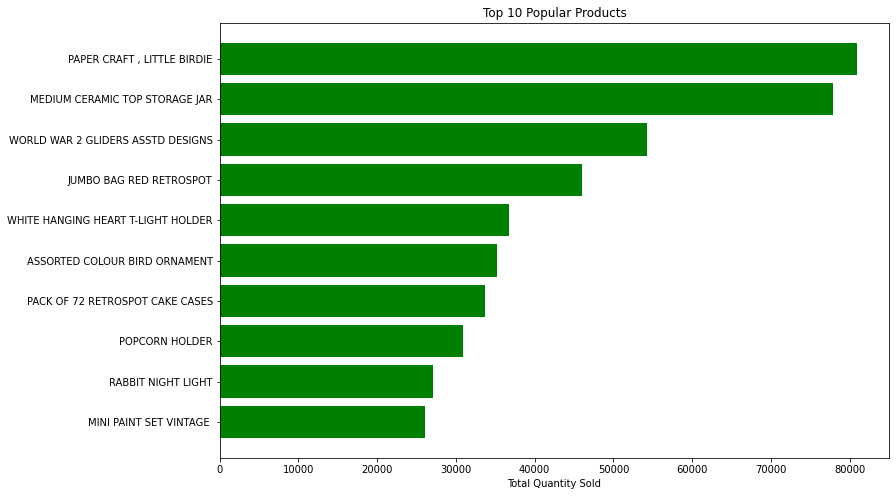

In [ ]:
data = sql('''
           SELECT Description, SUM(Quantity) as TotalQuantity
            FROM online_retail_cleaned
            GROUP BY Description
            ORDER BY TotalQuantity DESC
            LIMIT 10
           ''').toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(data['Description'], data['TotalQuantity'], color='green')
plt.xlabel('Total Quantity Sold')
plt.title('Top 10 Popular Products')
plt.gca().invert_yaxis()  # To display the highest values at the top
plt.show()

In [ ]:
%scala

val numericColumns = Seq("Quantity", "UnitPrice")
numericColumns.foreach { col =>
  df1.groupBy(col).count().orderBy(desc("count")).show(10)
}

+--------+-----+
Quantity|count|
+--------+-----+
 1|69592|
 12|59826|
 2|57421|
 6|37480|
 4|32090|
 3|26817|
 24|23691|
 10|21160|
 8|11594|
 5| 8098|
+--------+-----+
only showing top 10 rows

+---------+-----+
UnitPrice|count|
+---------+-----+
 1.25|45102|
 1.65|36286|
 2.95|26151|
 0.85|25658|
 0.42|21557|
 4.95|17916|
 3.75|17441|
 2.1|16890|
 2.08|15565|
 1.95|12515|
+---------+-----+
only showing top 10 rows

numericColumns: Seq[String] = List(Quantity, UnitPrice)

In [ ]:
%scala
val correlation = df1.stat.corr("Quantity", "UnitPrice")
println(s"Correlation between Quantity and UnitPrice: $correlation")

Correlation between Quantity and UnitPrice: -0.004578314349649017
correlation: Double = -0.004578314349649017

In [ ]:
%sql
SELECT Country, AVG(UnitPrice) as avg_unit_price
FROM online_retail_cleaned
GROUP BY Country
ORDER BY avg_unit_price DESC

Country,avg_unit_price
Singapore,58.33328828828829
Canada,6.030331125827815
Portugal,5.943860977288374
Cyprus,5.748175787728026
Lebanon,5.387555555555555
Finland,5.296992700729926
Norway,5.287086834733896
Malta,4.867767857142858
European Community,4.83
Italy,4.717955145118732


Interpretation:  	1.	High Average Unit Price Countries: 	•	Singapore: With an average unit price of 58.33, Singapore stands out significantly above all other countries, indicating that customers in Singapore tend to purchase much higher-priced items compared to other countries. 	•	Canada, Portugal, Cyprus, Lebanon, Finland, Norway: These countries have average unit prices ranging from about 5.29 to 6.03. This suggests that customers in these countries are purchasing moderately high-priced items. 	

2.Moderate Average Unit Price Countries: 	•	Malta, European Community, Italy, Bahrain, Greece: Average unit prices range from about 4.53 to 4.87. These prices are moderately high but not as high as those in the top tier. 	•	Channel Islands, Brazil, EIRE (Ireland), France, RSA: Average unit prices range from about 4.35 to 4.53, indicating a moderate spending pattern. 	

3.Lower Average Unit Price Countries: 	•	Austria, Poland, Spain, Sweden, Germany: Average unit prices are between 3.71 and 4.26. These countries have customers purchasing relatively lower-priced items. 	•	Israel, Belgium, Switzerland, United Arab Emirates, Unspecified: Average unit prices range from about 3.22 to 3.67. These are among the lower ranges of average unit prices. 	

4.Lowest Average Unit Price Countries: 	•	Denmark, Czech Republic, Australia, United Kingdom, Lithuania: These countries have average unit prices ranging from about 2.84 to 3.15, indicating that customers in these countries are purchasing more budget-friendly items. 	•	Netherlands, Iceland, Saudi Arabia, USA, Japan: With average unit prices ranging from about 2.05 to 2.64, these countries have the lowest average unit prices, suggesting that customers tend to buy lower-priced items.

In [ ]:
%sql
SELECT Country, round(SUM(Quantity * UnitPrice),2) as Total_sales
FROM online_retail_cleaned
GROUP BY Country
ORDER BY total_sales DESC

Country,Total_sales
United Kingdom,7285024.64
Netherlands,285446.34
EIRE,265262.46
Germany,228678.4
France,208934.31
Australia,138453.81
Spain,61558.56
Switzerland,56443.95
Belgium,41196.34
Sweden,38367.83


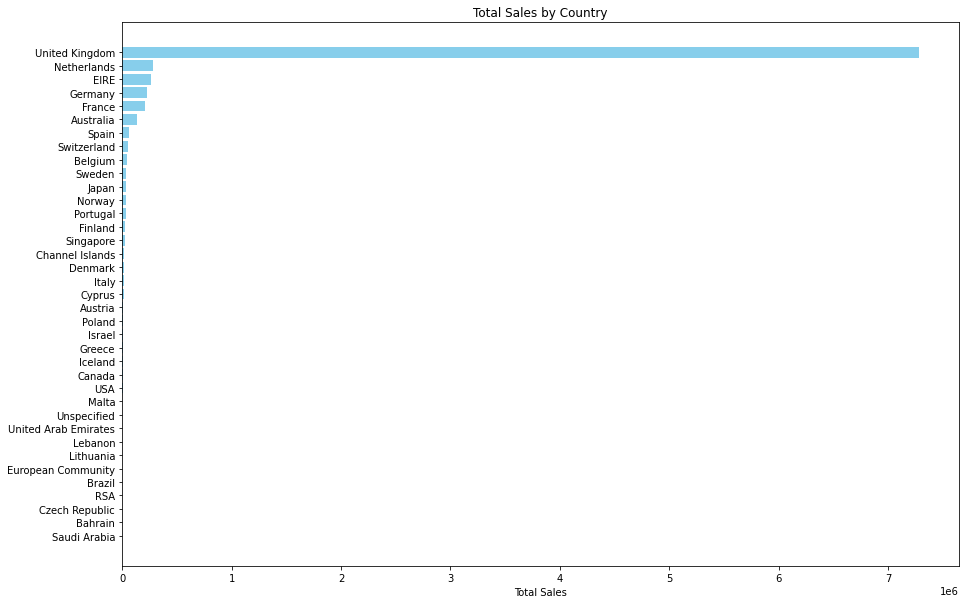

In [ ]:

# Data
data = sql('''
            SELECT Country, round(SUM(Quantity * UnitPrice),2) as Total_sales
              FROM online_retail_cleaned
              GROUP BY Country
              ORDER BY total_sales DESC
           ''').toPandas()

# Plotting
plt.figure(figsize=(15, 10))
plt.barh(data['Country'], data['Total_sales'], color='skyblue')
plt.xlabel('Total Sales')
plt.title('Total Sales by Country')
plt.gca().invert_yaxis()  # To display the highest values at the top
plt.show()

In [ ]:
%sql
SELECT Country, count(distinct CustomerID) as Customers
FROM online_retail_cleaned
GROUP BY Country
ORDER BY Customers desc

Country,Customers
United Kingdom,3920
Germany,94
France,87
Spain,30
Belgium,25
Switzerland,21
Portugal,19
Italy,14
Finland,12
Austria,11


Time Series Data Analysis

In [ ]:
%sql
SELECT DATE_FORMAT(InvoiceDate, 'yyyy-MM') as month, round(SUM(Quantity * UnitPrice),2) as total_sales
FROM online_retail_cleaned
GROUP BY month
ORDER BY month

month,total_sales
2010-12,570422.73
2011-01,568101.31
2011-02,446084.92
2011-03,594081.76
2011-04,468374.33
2011-05,677355.15
2011-06,660046.05
2011-07,598962.9
2011-08,644051.04
2011-09,950690.2


Out[5]: <AxesSubplot:xlabel='month'>

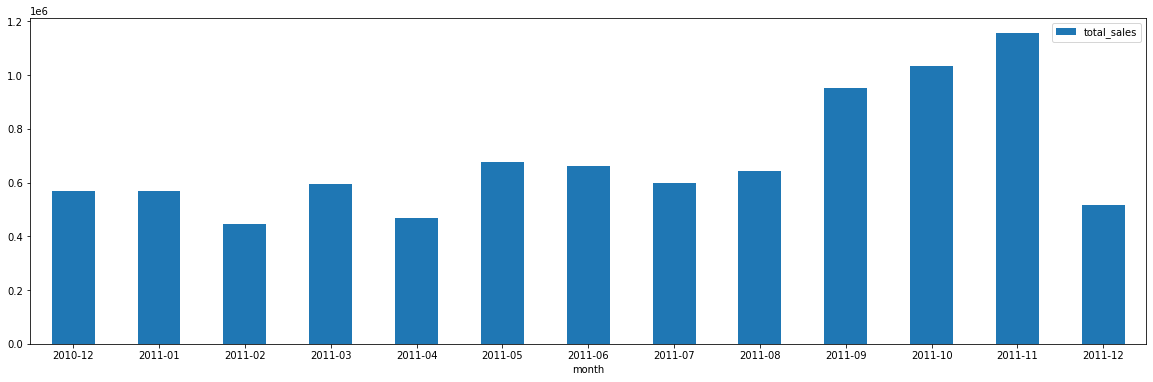

In [ ]:

data = sql(
    '''
    SELECT DATE_FORMAT(InvoiceDate, 'yyyy-MM') as month, round(SUM(Quantity * UnitPrice),2) as total_sales
        FROM online_retail_cleaned
        GROUP BY month
        ORDER BY month
    '''
).toPandas()

# Create Heatmap
fig = px.imshow(data[['total_sales']].transpose(), 
                labels=dict(x="Month", y="Total Sales", color="Sales"),
                x=data['month'], 
                y=['Total Sales'],
                color_continuous_scale='Viridis')

fig.update_layout(title='Monthly Total Sales Heatmap',
                  xaxis_title='Month',
                  yaxis_title='Total Sales')

fig.show()

data.plot.bar(x='month', y='total_sales', rot=0, figsize=(20,6))


### Part Two: Clustering Models 

#### Feature Engineering: Add FRM features
Implement the RFM approach to evaluate customers.

RFM is a method used for analyzing customer value and segmenting customers which is commonly used in marketing / Customer Relation. RFM stands for the three dimensions:

- Recency – How recently did the customer purchase?
- Frequency – How often do they purchase?
- Monetary Value – How much do they spend?

In [ ]:
%scala

df1.agg(max(df1("InvoiceDate"))).show()

+-------------------+
 max(InvoiceDate)|
+-------------------+
2011-12-09 12:50:00|
+-------------------+

In [ ]:
%scala

var maxDate = df1.agg(max(df1("InvoiceDate"))).first().get(0) //+ TimeUnit.DAYS.toMillis(1)
println(maxDate.getClass)
print(TimeUnit.DAYS.toMillis(1))

// Set anchor date as the max invoicedate  + 1 to calculate Recency
var anchorDate = sql("select dateadd(max(InvoiceDate),1) from online_retail_cleaned").first().get(0).toString
println(anchorDate)

class java.sql.Timestamp
864000002011-12-10
maxDate: Any = 2011-12-09 12:50:00.0
anchorDate: String = 2011-12-10

In [ ]:
%scala

// Feature: TotalAmount
val dfWithTotalAmount = df1.withColumn("TotalAmount", col("Quantity") * col("UnitPrice") )

// Feature: Recency, Frequency, Monetary
val dfWithDate = dfWithTotalAmount.withColumn("InvoiceDate", to_date(col("InvoiceDate"), "MM/dd/yyyy HH:mm:ss"))

val dfWithFeatures = dfWithDate
  .groupBy("CustomerID")
  .agg(
    min(datediff(lit(anchorDate), col("InvoiceDate"))).alias("Recency"),
    count("InvoiceNo").alias("Frequency"),
    round(sum("TotalAmount"),2).alias("MonetaryValue")
  )

// Register the featured DataFrame as a SQL temporary view
  dfWithFeatures.createOrReplaceTempView("dataWithFeatures")

  dfWithFeatures.show()

+----------+-------+---------+-------------+
CustomerID|Recency|Frequency|MonetaryValue|
+----------+-------+---------+-------------+
 15727| 17| 301| 5159.06|
 15447| 331| 9| 155.17|
 16503| 107| 84| 1431.93|
 17389| 1| 213| 31833.68|
 14450| 181| 40| 483.25|
 17420| 51| 30| 598.83|
 13623| 31| 78| 727.74|
 13285| 24| 187| 2709.12|
 14570| 281| 29| 218.06|
 16339| 285| 18| 94.05|
 16386| 29| 81| 302.57|
 18024| 153| 21| 389.78|
 17679| 53| 30| 1992.11|
 16574| 72| 28| 451.44|
 12940| 55| 96| 899.69|
 15957| 32| 42| 428.89|
 15790| 11| 34| 218.75|
 16916| 24| 136| 562.41|
 12471| 3| 459| 19788.65|
 14514| 62| 69| 990.2|
+----------+-------+---------+-------------+
only showing top 20 rows

dfWithTotalAmount: org.apache.spark.sql.DataFrame = [InvoiceNo: string, StockCode: string ... 7 more fields]
dfWithDate: org.apache.spark.sql.DataFrame = [InvoiceNo: string, StockCode: string ... 7 more fields]
dfWithFeatures: org.apache.spark.sql.DataFrame = [CustomerID: int, Recency: int ... 2 more fields]

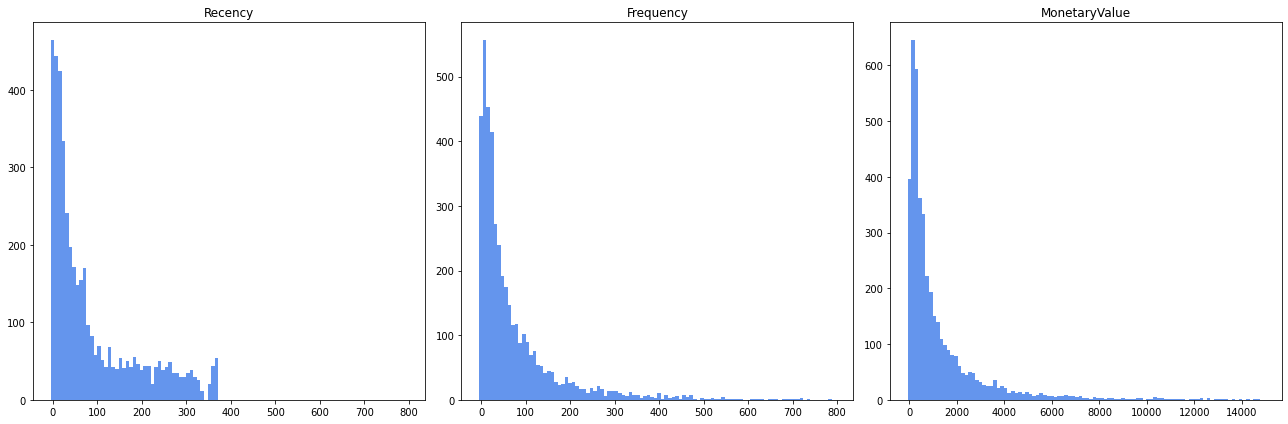

In [ ]:
# Check data distribution
data = sql('SELECT * from dataWithFeatures').toPandas()
data.head()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Flatten the array of axes for easier indexing
axes_flat = axes.flatten()

for i, col in enumerate(['Recency','Frequency','MonetaryValue']):
    # Check if the index is within the range of axes available to avoid IndexError
    if i < len(axes_flat):
        # sns.boxplot(x=target[0], y=col, data=df_eda.loc[:, target + discrete_vars + continuous_vars], ax=axes_flat[i])
        if col in  ['Recency','Frequency']:
            axes_flat[i].hist( data[col], bins=100, range=[0,800], align='left', color='cornflowerblue', label = col)
            axes_flat[i].set_title(col)
        else:
            axes_flat[i].hist( data[col], bins=100, range=[0,15000], align='left', color='cornflowerblue', label = col)
            axes_flat[i].set_title(col)
    else:
        print(f"No axis available for {col}")

# Adjust layout for better spacing between plots
plt.tight_layout()

#### All three features are right-skewed. When using distance-based models such as KMeans, these highly skewed values can mispresent the model results and hard to split clusters evenly, as KMeans relies on Euclidean distance. A good practice is to apply a logarithmic transformation to these features.
#### For distance calcuation algorithms such as K-means, it is important to scale dataset.
#### Will generate 2 KMeans models with normalized data as well as log transfered data to compare result.

#### K-means Clustering with normalized feature 

In [ ]:
%scala

// Assemble features for clustering
val assembler = new VectorAssembler()
  .setInputCols(Array("Recency", "Frequency", "MonetaryValue"))
  .setOutputCol("features")

val dfWithFeatureVector = assembler.transform(dfWithFeatures)

// Normalize the features
val scaler = new StandardScaler()
  .setInputCol("features")
  .setOutputCol("scaledFeatures")
  .setWithStd(true)
  .setWithMean(true)

val scalerModel = scaler.fit(dfWithFeatureVector)

val scaledData = scalerModel.transform(dfWithFeatureVector)

// Re-run K-means clustering on normalized data
val kmeans = new KMeans().setK(4).setSeed(1L).setFeaturesCol("scaledFeatures")
val model = kmeans.fit(scaledData)

// Make predictions
val predictions = model.transform(scaledData)
predictions.createOrReplaceTempView("customer_segments_normalized")

// Compute WSSSE
val WSSSE = model.summary.trainingCost
println(s"Within-Set Sum of Squared Errors (Normalized): $WSSSE")

// Evaluate clustering by computing Silhouette score
val evaluator = new ClusteringEvaluator().setFeaturesCol("scaledFeatures")
val silhouette = evaluator.evaluate(predictions)
println(s"Silhouette with squared euclidean distance (Normalized): $silhouette")

// Calculate the size of each cluster
val clusterSizes = predictions.groupBy("prediction").count().orderBy("prediction")
clusterSizes.show()


Within-Set Sum of Squared Errors (Normalized): 4037.43094156701
Silhouette with squared euclidean distance (Normalized): 0.7408364889601584
+----------+-----+
prediction|count|
+----------+-----+
 0| 1081|
 1| 3245|
 2| 6|
 3| 6|
+----------+-----+

assembler: org.apache.spark.ml.feature.VectorAssembler = VectorAssembler: uid=vecAssembler_4cd8d3fbf037, handleInvalid=error, numInputCols=3
dfWithFeatureVector: org.apache.spark.sql.DataFrame = [CustomerID: int, Recency: int ... 3 more fields]
scaler: org.apache.spark.ml.feature.StandardScaler = stdScal_c6c8d443f5c2
scalerModel: org.apache.spark.ml.feature.StandardScalerModel = StandardScalerModel: uid=stdScal_c6c8d443f5c2, numFeatures=3, withMean=true, withStd=true
scaledData: org.apache.spark.sql.DataFrame = [CustomerID: int, Recency: int ... 4 more fields]
kmeans: org.apache.spark.ml.clustering.KMeans = kmeans_4da76df52899
model: org.apache.spark.ml.clustering.KMeansModel = KMeansModel: uid=kmeans_4da76df52899, k=4, distanceMeasure=euclidean, numFeatures=3
predictions: org.apache.spark.sql.DataFrame = [CustomerID: int, Recency: int ... 5 more fields]
WSSSE: Double = 4037.43094156701
evaluator: org.apache.spark.ml.evaluation.ClusteringEvaluator = ClusteringEvaluator: uid=cluEval_04cb884e7698, metricName=silhouette, distanceMeasure=squaredEuclidean
silhouette: Double = 0.7408364889601584
clusterSizes: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [prediction: int, count: bigint]

In [ ]:

# Load the clustering results into a Pandas DataFrame
clustering_results = spark.sql("""
SELECT 
  CustomerID, 
  Recency, 
  Frequency, 
  MonetaryValue, 
  prediction AS CustomerSegment
FROM 
  customer_segments_normalized
""").toPandas()

# Define custom color sequence
custom_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']

# 3D Scatter Plot
fig = px.scatter_3d(clustering_results, x='Recency', y='Frequency', z='MonetaryValue',
                    color='CustomerSegment', title='Customer Segments Visualization in 3D',
                    labels={'Recency': 'Recency', 'Frequency': 'Frequency', 'MonetaryValue': 'Monetary Value'},
                    width=900, height=700,
                    color_discrete_map={
                        '0': '#636EFA',
                        '1': '#EF553B',
                        '2': '#00CC96',
                        '3': '#AB63FA'
                    })

fig.show()

#### K-means Clustering with log-transformed feature


In [ ]:
%scala
val dfWithFeatures_log = dfWithFeatures.withColumn("Recency_log", log(col("Recency"))  ) 
                                      .withColumn("Frequency_log", log(col("Frequency"))  ) 
                                      .withColumn("Monetary_log", log(col("MonetaryValue"))  )

dfWithFeatures_log.createOrReplaceTempView("DataWithFeatures_log")

dfWithFeatures_log.show()

+----------+-------+---------+-------------+------------------+------------------+------------------+
CustomerID|Recency|Frequency|MonetaryValue| Recency_log| Frequency_log| Monetary_log|
+----------+-------+---------+-------------+------------------+------------------+------------------+
 15727| 17| 301| 5159.06| 2.833213344056216| 5.707110264748875| 8.548509671337904|
 15447| 331| 9| 155.17| 5.802118375377063|2.1972245773362196| 5.044521290095393|
 16503| 107| 84| 1431.93| 4.672828834461906| 4.430816798843313| 7.266778463644229|
 17389| 1| 213| 31833.68| 0.0|5.3612921657094255|10.368280127793772|
 14450| 181| 40| 483.25| 5.198497031265826|3.6888794541139363| 6.18053411808844|
 17420| 51| 30| 598.83|3.9318256327243257|3.4011973816621555| 6.394977751490901|
 13623| 31| 78| 727.74|3.4339872044851463| 4.356708826689592| 6.589943841548844|
 13285| 24| 187| 2709.12|3.1780538303479458| 5.231108616854587| 7.904379137892504|
 14570| 281| 29| 218.06| 5.638354669333745| 3.367295829986474| 5.384770254278235|
 16339| 285| 18| 94.05| 5.652489180268651|2.8903717578961645| 4.54382655574704|
 16386| 29| 81| 302.57| 3.367295829986474| 4.394449154672439| 5.712312655659576|
 18024| 153| 21| 389.78| 5.030437921392435| 3.044522437723423| 5.965582477393878|
 17679| 53| 30| 1992.11| 3.970291913552122|3.4011973816621555| 7.596949657503461|
 16574| 72| 28| 451.44| 4.276666119016055| 3.332204510175204|6.1124424736608844|
 12940| 55| 96| 899.69| 4.007333185232471| 4.564348191467836| 6.802050259545253|
 15957| 32| 42| 428.89|3.4657359027997265|3.7376696182833684| 6.061200475792877|
 15790| 11| 34| 218.75|2.3978952727983707|3.5263605246161616| 5.387929525237724|
 16916| 24| 136| 562.41|3.1780538303479458| 4.912654885736052| 6.33223112127721|
 12471| 3| 459| 19788.65|1.0986122886681096| 6.129050210060545| 9.892863819998931|
 14514| 62| 69| 990.2| 4.127134385045092| 4.23410650459726| 6.897906942927323|
+----------+-------+---------+-------------+------------------+------------------+------------------+
only showing top 20 rows

dfWithFeatures_log: org.apache.spark.sql.DataFrame = [CustomerID: int, Recency: int ... 5 more fields]

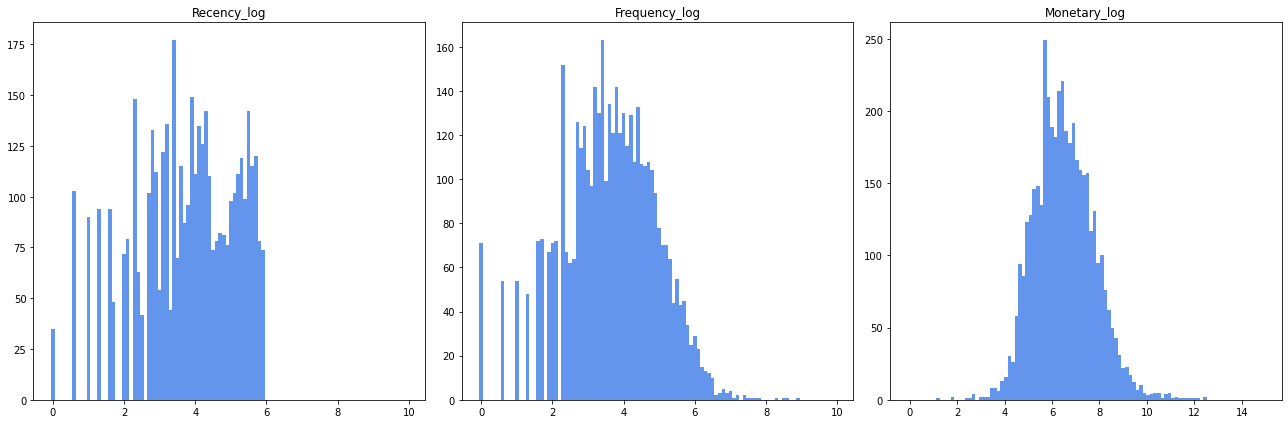

In [ ]:
# Check data distribution, after taking the logarithm, the distributions are close to normal and their scales are the same.
data = sql('SELECT CustomerID, Recency_log, Frequency_log, Monetary_log from dataWithFeatures_log').toPandas()
data.head()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Flatten the array of axes for easier indexing
axes_flat = axes.flatten()

for i, col in enumerate(['Recency_log','Frequency_log','Monetary_log']):
    # Check if the index is within the range of axes available to avoid IndexError
    if i < len(axes_flat):
        # sns.boxplot(x=target[0], y=col, data=df_eda.loc[:, target + discrete_vars + continuous_vars], ax=axes_flat[i])
        if col in  ['Recency_log','Frequency_log']:
            axes_flat[i].hist( data[col], bins=100, range=[0,10], align='left', color='cornflowerblue', label = col)
            axes_flat[i].set_title(col)
        else:
            axes_flat[i].hist( data[col], bins=100, range=[0,15], align='left', color='cornflowerblue', label = col)
            axes_flat[i].set_title(col)
    else:
        print(f"No axis available for {col}")

# Adjust layout for better spacing between plots
plt.tight_layout()

In [ ]:
%scala
dfWithFeatures_log.select("CustomerID", "Recency_log", "Frequency_log", "Monetary_log").show()

+----------+------------------+------------------+------------------+
CustomerID| Recency_log| Frequency_log| Monetary_log|
+----------+------------------+------------------+------------------+
 15727| 2.833213344056216| 5.707110264748875| 8.548509671337904|
 15447| 5.802118375377063|2.1972245773362196| 5.044521290095393|
 16503| 4.672828834461906| 4.430816798843313| 7.266778463644229|
 17389| 0.0|5.3612921657094255|10.368280127793772|
 14450| 5.198497031265826|3.6888794541139363| 6.18053411808844|
 17420|3.9318256327243257|3.4011973816621555| 6.394977751490901|
 13623|3.4339872044851463| 4.356708826689592| 6.589943841548844|
 13285|3.1780538303479458| 5.231108616854587| 7.904379137892504|
 14570| 5.638354669333745| 3.367295829986474| 5.384770254278235|
 16339| 5.652489180268651|2.8903717578961645| 4.54382655574704|
 16386| 3.367295829986474| 4.394449154672439| 5.712312655659576|
 18024| 5.030437921392435| 3.044522437723423| 5.965582477393878|
 17679| 3.970291913552122|3.4011973816621555| 7.596949657503461|
 16574| 4.276666119016055| 3.332204510175204|6.1124424736608844|
 12940| 4.007333185232471| 4.564348191467836| 6.802050259545253|
 15957|3.4657359027997265|3.7376696182833684| 6.061200475792877|
 15790|2.3978952727983707|3.5263605246161616| 5.387929525237724|
 16916|3.1780538303479458| 4.912654885736052| 6.33223112127721|
 12471|1.0986122886681096| 6.129050210060545| 9.892863819998931|
 14514| 4.127134385045092| 4.23410650459726| 6.897906942927323|
+----------+------------------+------------------+------------------+
only showing top 20 rows

In [ ]:
%scala
// Assemble features for clustering
val assembler = new VectorAssembler()
  .setInputCols(Array("Recency_log", "Frequency_log", "Monetary_log"))
  .setOutputCol("features")

var df_log = dfWithFeatures_log.select("CustomerID", "Recency_log", "Frequency_log", "Monetary_log")
val dfWithFeatureVector_log = assembler.transform(df_log)


val inertias = scala.collection.mutable.ListBuffer.empty[(Int, Double)]

for (k <- 2 until 10) {
  val kmeans = new KMeans().setK(k).setSeed(42)
  val model = kmeans.fit(dfWithFeatureVector_log)
  val WSSSE = model.summary.trainingCost
  inertias.append((k, WSSSE))
  println(s"WSSSE when k is $k: $WSSSE")
}

val schema = StructType(Seq(
    StructField("k", IntegerType, true),
    StructField("Error", DoubleType, true)
    ))


val df_k = inertias.toDF("k", "WSSSE")

df_k.show()


WSSSE when k is 2: 12075.377998259342
WSSSE when k is 3: 9349.076493846242
WSSSE when k is 4: 8018.524391658333
WSSSE when k is 5: 6555.003596563546
WSSSE when k is 6: 5884.935906728551
WSSSE when k is 7: 5286.463627370725
WSSSE when k is 8: 4841.174979959324
WSSSE when k is 9: 4584.081230884442
+---+------------------+
 k| WSSSE|
+---+------------------+
 2|12075.377998259342|
 3| 9349.076493846242|
 4| 8018.524391658333|
 5| 6555.003596563546|
 6| 5884.935906728551|
 7| 5286.463627370725|
 8| 4841.174979959324|
 9| 4584.081230884442|
+---+------------------+

assembler: org.apache.spark.ml.feature.VectorAssembler = VectorAssembler: uid=vecAssembler_0917dd3dfb10, handleInvalid=error, numInputCols=3
df_log: org.apache.spark.sql.DataFrame = [CustomerID: int, Recency_log: double ... 2 more fields]
dfWithFeatureVector_log: org.apache.spark.sql.DataFrame = [CustomerID: int, Recency_log: double ... 3 more fields]
inertias: scala.collection.mutable.ListBuffer[(Int, Double)] = ListBuffer((2,12075.377998259342), (3,9349.076493846242), (4,8018.524391658333), (5,6555.003596563546), (6,5884.935906728551), (7,5286.463627370725), (8,4841.174979959324), (9,4584.081230884442))
schema: org.apache.spark.sql.types.StructType = StructType(StructField(k,IntegerType,true),StructField(Error,DoubleType,true))
df_k: org.apache.spark.sql.DataFrame = [k: int, WSSSE: double]

In [ ]:
%scala
// show Distortion Score Elbow for KMeans Cluster, choose cluster number as 4
display(df_k)

k,WSSSE
2,12075.377998259342
3,9349.076493846242
4,8018.524391658333
5,6555.003596563546
6,5884.935906728551
7,5286.463627370725
8,4841.174979959324
9,4584.081230884442


Databricks visualization. Run in Databricks to view.

In [ ]:
println(inertias)

ArrayBuffer(12075.377998259342, 9349.076493846242, 8018.524391658333, 6555.003596563546, 5884.935906728551, 5286.463627370725, 4841.174979959324, 4584.081230884442)

In [ ]:
%scala
// Assemble features for clustering
val assembler = new VectorAssembler()
  .setInputCols(Array("Recency_log", "Frequency_log", "Monetary_log"))
  .setOutputCol("features")

var df_log = dfWithFeatures_log.select("CustomerID", "Recency_log", "Frequency_log", "Monetary_log")
val dfWithFeatureVector_log = assembler.transform(df_log)

// K-Means Clustering
val kmeans = new KMeans().setK(4).setSeed(1L)
val model = kmeans.fit(dfWithFeatureVector_log)

// Make predictions
val predictions_log = model.transform(dfWithFeatureVector_log)
predictions_log.createOrReplaceTempView("customer_segments_log")

predictions_log.show()

// Compute WSSSE
val WSSSE = model.summary.trainingCost
println(s"Within-Set Sum of Squared Errors (Log Transform): $WSSSE")

// Evaluate clustering by computing Silhouette score
val evaluator = new ClusteringEvaluator().setFeaturesCol("features")
val silhouette = evaluator.evaluate(predictions_log)
println(s"Silhouette with squared euclidean distance (log Transform): $silhouette")

// Calculate the size of each cluster
val clusterSizes = predictions_log.groupBy("prediction").count().orderBy("prediction")
clusterSizes.show()


+----------+------------------+------------------+------------------+--------------------+----------+
CustomerID| Recency_log| Frequency_log| Monetary_log| features|prediction|
+----------+------------------+------------------+------------------+--------------------+----------+
 15727| 2.833213344056216| 5.707110264748875| 8.548509671337904|[2.83321334405621...| 3|
 15447| 5.802118375377063|2.1972245773362196| 5.044521290095393|[5.80211837537706...| 0|
 16503| 4.672828834461906| 4.430816798843313| 7.266778463644229|[4.67282883446190...| 1|
 17389| 0.0|5.3612921657094255|10.368280127793772|[0.0,5.3612921657...| 3|
 14450| 5.198497031265826|3.6888794541139363| 6.18053411808844|[5.19849703126582...| 0|
 17420|3.9318256327243257|3.4011973816621555| 6.394977751490901|[3.93182563272432...| 1|
 13623|3.4339872044851463| 4.356708826689592| 6.589943841548844|[3.43398720448514...| 1|
 13285|3.1780538303479458| 5.231108616854587| 7.904379137892504|[3.17805383034794...| 3|
 14570| 5.638354669333745| 3.367295829986474| 5.384770254278235|[5.63835466933374...| 0|
 16339| 5.652489180268651|2.8903717578961645| 4.54382655574704|[5.65248918026865...| 0|
 16386| 3.367295829986474| 4.394449154672439| 5.712312655659576|[3.36729582998647...| 1|
 18024| 5.030437921392435| 3.044522437723423| 5.965582477393878|[5.03043792139243...| 0|
 17679| 3.970291913552122|3.4011973816621555| 7.596949657503461|[3.97029191355212...| 1|
 16574| 4.276666119016055| 3.332204510175204|6.1124424736608844|[4.27666611901605...| 1|
 12940| 4.007333185232471| 4.564348191467836| 6.802050259545253|[4.00733318523247...| 1|
 15957|3.4657359027997265|3.7376696182833684| 6.061200475792877|[3.46573590279972...| 2|
 15790|2.3978952727983707|3.5263605246161616| 5.387929525237724|[2.39789527279837...| 2|
 16916|3.1780538303479458| 4.912654885736052| 6.33223112127721|[3.17805383034794...| 1|
 12471|1.0986122886681096| 6.129050210060545| 9.892863819998931|[1.09861228866810...| 3|
 14514| 4.127134385045092| 4.23410650459726| 6.897906942927323|[4.12713438504509...| 1|
+----------+------------------+------------------+------------------+--------------------+----------+
only showing top 20 rows

Within-Set Sum of Squared Errors (Normalized): 7810.106352610864
Silhouette with squared euclidean distance (log Transform): 0.4620679661517872
+----------+-----+
prediction|count|
+----------+-----+
 0| 1240|
 1| 1415|
 2| 806|
 3| 877|
+----------+-----+

assembler: org.apache.spark.ml.feature.VectorAssembler = VectorAssembler: uid=vecAssembler_2684c11b0b7c, handleInvalid=error, numInputCols=3
df_log: org.apache.spark.sql.DataFrame = [CustomerID: int, Recency_log: double ... 2 more fields]
dfWithFeatureVector_log: org.apache.spark.sql.DataFrame = [CustomerID: int, Recency_log: double ... 3 more fields]
kmeans: org.apache.spark.ml.clustering.KMeans = kmeans_8ccbffc32e64
model: org.apache.spark.ml.clustering.KMeansModel = KMeansModel: uid=kmeans_8ccbffc32e64, k=4, distanceMeasure=euclidean, numFeatures=3
predictions_log: org.apache.spark.sql.DataFrame = [CustomerID: int, Recency_log: double ... 4 more fields]
WSSSE: Double = 7810.106352610864
evaluator: org.apache.spark.ml.evaluation.ClusteringEvaluator = ClusteringEvaluator: uid=cluEval_79df0cdeac59, metricName=silhouette, distanceMeasure=squaredEuclidean
silhouette: Double = 0.4620679661517872
clusterSizes: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [prediction: int, count: bigint]

In [ ]:
# Load the clustering results into a Pandas DataFrame
clustering_results = spark.sql("""
SELECT 
  CustomerID, 
  Recency_log, 
  Frequency_log, 
  Monetary_log, 
  prediction AS customer_segments
FROM 
  customer_segments_log
""").toPandas()

# Define custom color sequence
custom_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']

# 3D Scatter Plot
fig = px.scatter_3d(clustering_results, x='Recency_log', y='Frequency_log', z='Monetary_log',
                    color='customer_segments', title='Customer Segments Visualization in 3D',
                    labels={'Recency_log': 'Recency_log', 'Frequency_log': 'Frequency_log', 'Monetary_log': 'Monetary_log'},
                    width=900, height=700,
                    color_discrete_map={
                        '0': '#636EFA',
                        '1': '#EF553B',
                        '2': '#00CC96',
                        '3': '#AB63FA'
                    })

fig.show()

In [ ]:
%sql
select prediction, round(avg(Recency),2) Avg_Recency, round(avg(Frequency),2) Avg_Frequency, round(avg(MonetaryValue),2) Avg_Monetary, count(a.CustomerID) Customer_Counts
from dataWithFeatures as a inner join customer_segments_log b on a.CustomerID = b.CustomerID
group by prediction
order by prediction


prediction,Avg_Recency,Avg_Frequency,Avg_Monetary,Customer_Counts
0,210.24,16.26,323.34,1240
1,78.45,83.6,1544.59,1415
2,27.91,24.67,409.08,806
3,10.82,267.22,6808.39,877


#### Model Explanation: split customers into 4 clusters
- Group 0: customers who haven't purchase more than 6 months and not frequently purchase in the past, money spend is also low, these are not important customers.
- Group 1: customers who purchased in last 3 months, also frequently purchased in the past with high money spend, these are valuable customers who may have risk of losing them, need to implement market strategy to enchance loyality.
- Group 2: customers who recently purchased within 1 month, with low frequentcy and low money spend, these are new customers, need to implement market strategy to attract them with more service/production.
- Group 3: customers who purchase recently and also frequently with high money amount spend, these are most important customers to keep.

#### Comparing feature engineering for normalization VS logarithmic transformation
- Logarithmic transformation can transform skewed data to be more normalizd distribution and thus have better chance to cluster data evenly. 

### Clustering with DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based unsupervised learning algorithm. It computes nearest neighbor graphs to find arbitrary-shaped clusters and outliers. Whereas the K-means clustering generates spherical-shaped clusters. 

DBSCAN does not require K clusters initially. Instead, it requires two parameters: eps and minPts.
- eps: it is the radius of specific neighborhoods. If the distance between two points is less than or equal to esp, it will be considered its neighbors.
- minPts: minimum number of data points in a given neighborhood to form the clusters. 

DBSCAN uses these two parameters to define a core point, border point, or outlier.

#### NearestNeighbors to find optimal 'eps' in DBSCAN

In [ ]:
df_log = spark.sql("""
SELECT 
  CustomerID, 
  Recency_log, 
  Frequency_log, 
  Monetary_log
FROM 
  DataWithFeatures_log
""").toPandas()
features = ['Recency_log', 'Frequency_log','Monetary_log']

#st = StandardScaler()
#df_std = pd.DataFrame(st.fit_transform(df_org[features]), columns=features)


nn = NearestNeighbors(n_neighbors=20).fit(df_log[features])
distances, indices = nn.kneighbors(df_log[features])

Out[15]: [<matplotlib.lines.Line2D at 0x7fd74220d100>]

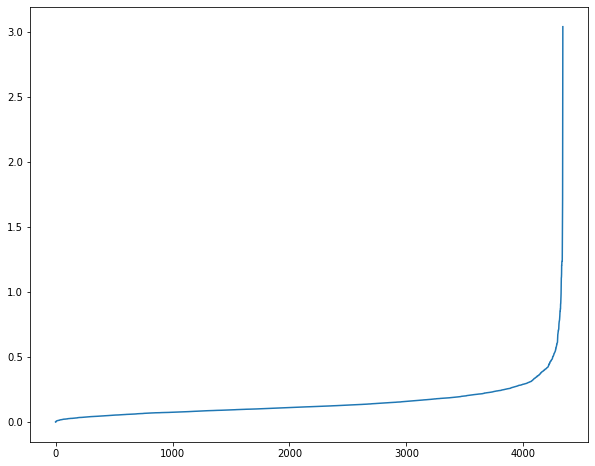

In [ ]:
# plot the distances of each point in ascending order of the distance, elbow point will give us the samller range for optimal eps value.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)

In [ ]:
# consider eps range 0.4 to 0.6 and _min_sample_ range 600 to 800 and iterate over these combinations and get the best silhouette score.
min_samples = range(8,15)
eps = np.arange(0.4,1, 0.1) 

output = []

for ms in min_samples:
    for ep in eps:
        labels = DBSCAN(min_samples=ms, eps = ep).fit(df_log[features]).labels_
        score = silhouette_score(df_log[features], labels)
        output.append((ms, ep, score, labels.max()+1))
        print(f"(ep, ms): ({ep}, {ms}) with {labels.max()+1} clusters,  silhouette_score is {score }")

min_samples, eps, score, cluster = sorted(output, key=lambda x:x[2])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

(ep, ms): (0.4, 8) with 6 clusters,  silhouette_score is -0.053510225021371975
(ep, ms): (0.5, 8) with 3 clusters,  silhouette_score is 0.16307639776726612
(ep, ms): (0.6, 8) with 4 clusters,  silhouette_score is 0.12583846959793663
(ep, ms): (0.7, 8) with 1 clusters,  silhouette_score is 0.43935398236915335
(ep, ms): (0.7999999999999999, 8) with 1 clusters,  silhouette_score is 0.48244563885229225
(ep, ms): (0.8999999999999999, 8) with 1 clusters,  silhouette_score is 0.5023732811404088
(ep, ms): (0.4, 9) with 4 clusters,  silhouette_score is -0.01623250296588556
(ep, ms): (0.5, 9) with 2 clusters,  silhouette_score is 0.2392409260441274
(ep, ms): (0.6, 9) with 2 clusters,  silhouette_score is 0.2632894233435023
(ep, ms): (0.7, 9) with 2 clusters,  silhouette_score is 0.3294054833931217
(ep, ms): (0.7999999999999999, 9) with 1 clusters,  silhouette_score is 0.47956316828727985
(ep, ms): (0.8999999999999999, 9) with 1 clusters,  silhouette_score is 0.49589461268310225
(ep, ms): (0.4, 1

In [ ]:
df_output = pd.DataFrame(output, columns=['min_samples', 'epsilon', 'silhouette', 'Cluster'])
df_output.sort_values('epsilon').head(42)

,min_samples,epsilon,silhouette,Cluster
0,8,0.4,-0.053510,6
24,12,0.4,0.056869,4
12,10,0.4,-0.023096,5
30,13,0.4,0.052403,4
6,9,0.4,-0.016233,4
18,11,0.4,0.044914,5
36,14,0.4,-0.076688,3
7,9,0.5,0.239241,2
19,11,0.5,0.167303,3
37,14,0.5,0.227938,2


In [ ]:
labels = DBSCAN(min_samples=8, eps = 0.9).fit(df_log[features]).labels_
df_log['prediction'] = labels
df_log.head()

,CustomerID,Recency_log,Frequency_log,Monetary_log,prediction
0,15727,2.833213,5.707110,8.548510,0
1,15447,5.802118,2.197225,5.044521,0
2,16503,4.672829,4.430817,7.266778,0
3,17389,0.000000,5.361292,10.368280,0
4,14450,5.198497,3.688879,6.180534,0


In [ ]:
df_log.groupby('prediction').agg({'Recency_log':'mean','Frequency_log':'mean','Monetary_log':'mean', 'CustomerID':'count'})

,Recency_log,Frequency_log,Monetary_log,CustomerID
prediction,,,,
-1,2.349770,3.919540,9.145895,41
0,3.814902,3.669156,6.561276,4297


### Conclusion
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based unsupervised learning algorithm. It computes nearest neighbor graphs to find arbitrary-shaped clusters and outliers. Whereas the K-means clustering generates spherical-shaped clusters. 

DBSCAN does not require K clusters initially. Instead, it requires two parameters: eps and minPts.
•	eps: it is the radius of specific neighborhoods. If the distance between two points is less than or equal to esp, it will be considered its neighbors.
•	minPts: minimum number of data points in a given neighborhood to form the clusters. 
DBSCAN uses these two parameters to define a core point, border point, or outlier.

eps is important to clustering performance, small eps can end up with overfitting of too many clusters and low silhouette score, while too big eps can end up with underfitting of too few clusters. 

K-means need to work with convex data, while DBSCAN can work with non-convex data, DBSCAN works best with data clusters having clear boundaries from each other. 

DBSCAN works based on data density, if most data are close to each other, DBSCAN will group them together as one cluster, instead of splitting data further into smaller clusters like what K-Means works. 

The other approach is to test with HDBSCAN, which utilize hierarchical clustering. In this approach, the algorithm considers clusters at various levels of granularity, allowing for the identification of clusters within clusters and resulting in a hierarchical structure. HDBSCAN is well-suited for datasets exhibiting variable-density clusters, while DBSCAN excels when clusters have a uniform shape and are separated by regions of lower point density. 
